#Import thư viện

In [28]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#ACB

Đọc và tiền xử lý dữ liệu

In [29]:
# Chuẩn bị dữ liệu

path ="/content/drive/MyDrive/Colab Notebooks/Data Analysis in Business 1/DATASET/ACB Historical Data.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)

# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data = data.reset_index(drop=True)

data

,Price,Open,High,Low,Vol.,Change %
0,10537.7,10477.8,10567.6,10417.9,7360000,0.0086
1,10926.9,10537.7,10956.8,10537.7,9450000,0.0369
2,10477.8,10956.8,10956.8,10477.8,8189999,-0.0411
3,10447.9,10447.9,10627.5,10328.1,9810000,-0.0029
4,10837.1,10447.9,10837.1,10447.9,8300000,0.0373
...,...,...,...,...,...,...
1506,22800.0,22700.0,22800.0,22650.0,6390000,0.0022
1507,23050.0,22800.0,23100.0,22800.0,11470000,0.0110
1508,23200.0,23050.0,23250.0,23050.0,8860000,0.0065
1509,23250.0,23200.0,23250.0,23050.0,7080000,0.0022


Phân chia dữ liệu

In [30]:
# Scaler data
price = data['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test validate
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
#val_size = len(price_scaled) - train_size - test_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
#val_data = price_scaled[train_size+test_size:]

Xây dựng thuật toán

In [31]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [32]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [33]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])
X_train, y_train

(array([[0.0821692 , 0.10019031, 0.07939565, ..., 0.14593298, 0.14870653,
         0.13622788],
        [0.10019031, 0.07939565, 0.0780112 , ..., 0.14870653, 0.13622788,
         0.13484343],
        [0.07939565, 0.0780112 , 0.0960323 , ..., 0.13622788, 0.13484343,
         0.13206988],
        ...,
        [0.80737976, 0.82034459, 0.82960517, ..., 0.87035176, 0.86664753,
         0.84997847],
        [0.82034459, 0.82960517, 0.81849247, ..., 0.86664753, 0.84997847,
         0.84812635],
        [0.82960517, 0.81849247, 0.80737976, ..., 0.84997847, 0.84812635,
         0.81293612]]),
 array([0.13484343, 0.13206988, 0.13484343, ..., 0.84812635, 0.81293612,
        0.83330941]))

In [34]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [35]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])
test_predict

array([[26527.2 ],
       [25972.16],
       [25889.6 ],
       [25571.2 ],
       [25782.4 ],
       [25520.  ],
       [25603.2 ],
       [25567.2 ],
       [25588.8 ],
       [26225.76],
       [25885.6 ],
       [25863.2 ],
       [25560.8 ],
       [25380.  ],
       [25389.12],
       [25465.12],
       [25342.56],
       [24901.76],
       [24784.48],
       [24547.68],
       [24416.48],
       [24701.76],
       [24699.2 ],
       [24331.36],
       [24161.76],
       [24485.12],
       [24468.8 ],
       [24657.44],
       [24727.68],
       [24514.08],
       [24885.28],
       [25012.16],
       [25131.36],
       [25109.44],
       [25115.36],
       [25708.96],
       [25924.96],
       [25297.76],
       [25101.12],
       [25187.04],
       [25242.56],
       [25127.68],
       [24975.84],
       [25177.44],
       [24943.2 ],
       [24891.04],
       [24683.36],
       [25002.24],
       [24996.48],
       [24926.24],
       [24965.6 ],
       [24968.16],
       [2508

Dự báo 30 ngày kế

In [36]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = data['Price'].values[-30:]
next_30_days = []

for i in range(30):
    x = last_30_days[-time_step:].reshape(1, time_step)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)



[[29524.8]
 [29524.8]
 [29524.8]
 [29524.8]
 [29524.8]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]
 [29566.4]]


Vẽ đồ thị

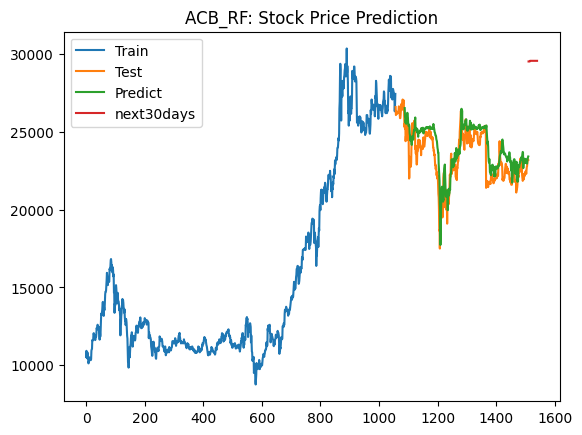

In [37]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")
# plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size+31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="next30days")


# # Dự đoán 30 điểm tiếp theo
plt.legend()
plt.title('ACB_RF: Stock Price Prediction')
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
import numpy as np
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(y_test[0], test_predict[:, 0])


print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')


RMSE trên tập test là: 1048.880686604945
MAPE trên tập test là: 3.690759908597243 %
MDA trên tập test là: 41.943127962085306 %


#PVS

Đọc và tiền xử lý dữ liệu

In [39]:
# Chuẩn bị dữ liệu

path ="/content/drive/MyDrive/Colab Notebooks/Data Analysis in Business 1/DATASET/PVS Historical Data.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)

# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data = data.reset_index(drop=True)

data

,Price,Open,High,Low,Vol.,Change %
0,17292.0,16746.0,17474.0,16655.0,12030000,0.0440
1,17838.0,17383.0,17838.0,17383.0,6600000,0.0316
2,17292.0,18020.0,18020.0,17292.0,6460000,-0.0306
3,17565.0,17201.0,17656.0,16837.0,8730000,0.0158
4,17110.0,17383.0,17474.0,17019.0,6100000,-0.0259
...,...,...,...,...,...,...
1511,37400.0,37500.0,38000.0,37400.0,1840000,-0.0027
1512,37900.0,37600.0,37900.0,37100.0,2540000,0.0134
1513,38400.0,37900.0,38600.0,37900.0,3040000,0.0132
1514,38200.0,37400.0,38700.0,37400.0,1440000,-0.0052


Phân chia dữ liệu

In [40]:
# Scaler data
price = data['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test validate
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
#val_size = len(price_scaled) - train_size - test_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
#val_data = price_scaled[train_size+test_size:]

Xây dựng thuật toán

In [41]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [42]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [43]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])
X_train, y_train

(array([[0.26157729, 0.27880126, 0.26157729, ..., 0.54293375, 0.52570978,
         0.49987382],
        [0.27880126, 0.26157729, 0.27018927, ..., 0.52570978, 0.49987382,
         0.52570978],
        [0.26157729, 0.27018927, 0.25583596, ..., 0.49987382, 0.52570978,
         0.51709779],
        ...,
        [0.56160883, 0.55548896, 0.58602524, ..., 0.72949527, 0.77832808,
         0.7477918 ],
        [0.55548896, 0.58602524, 0.55548896, ..., 0.77832808, 0.7477918 ,
         0.78138801],
        [0.58602524, 0.55548896, 0.56769716, ..., 0.7477918 , 0.78138801,
         0.7844164 ]]),
 array([0.52570978, 0.51709779, 0.50561514, ..., 0.78138801, 0.7844164 ,
        0.85463722]))

In [44]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [45]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])
test_predict

array([[30965.7 ],
       [30648.32],
       [30648.32],
       [26121.88],
       [23983.66],
       [22176.14],
       [20938.7 ],
       [22550.12],
       [22520.28],
       [22665.24],
       [23702.12],
       [24496.  ],
       [25237.46],
       [22728.38],
       [21195.14],
       [22426.98],
       [24442.9 ],
       [21994.46],
       [22271.34],
       [24535.04],
       [26866.64],
       [25719.3 ],
       [28334.92],
       [26582.16],
       [27606.9 ],
       [26786.94],
       [28230.64],
       [27917.56],
       [28243.24],
       [28402.46],
       [28766.06],
       [30083.24],
       [28774.06],
       [28485.68],
       [28630.64],
       [33269.6 ],
       [30586.98],
       [33518.12],
       [28227.12],
       [25645.66],
       [28221.68],
       [28366.2 ],
       [28913.84],
       [28716.1 ],
       [26065.44],
       [23732.9 ],
       [21322.2 ],
       [23438.2 ],
       [22651.9 ],
       [23401.18],
       [23998.04],
       [24090.4 ],
       [2263

Dự báo 30 ngày kế

In [46]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = data['Price'].values[-30:]
next_30_days = []

for i in range(30):
    x = last_30_days[-time_step:].reshape(1, time_step)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)


[[34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]
 [34514.7]]


Vẽ đồ thị

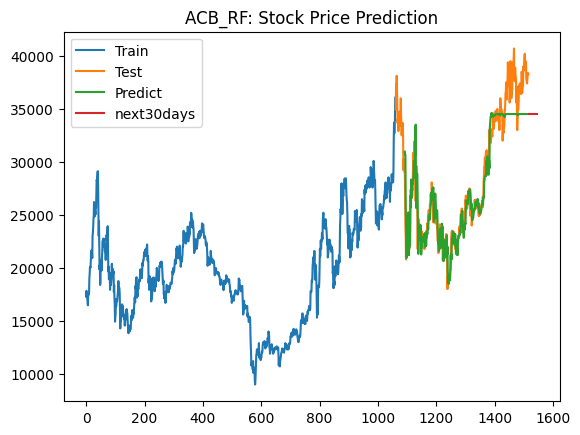

In [47]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")
# plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size+31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="next30days")


# # Dự đoán 30 điểm tiếp theo
plt.legend()
plt.title('ACB_RF: Stock Price Prediction')
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
import numpy as np
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(y_test[0], test_predict[:, 0])


print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')


RMSE trên tập test là: 1750.3806047413575
MAPE trên tập test là: 3.9950960233048742 %
MDA trên tập test là: 32.38770685579196 %


#VNM

Đọc và tiền xử lý dữ liệu

In [49]:
# Chuẩn bị dữ liệu

path ="/content/drive/MyDrive/Colab Notebooks/Data Analysis in Business 1/DATASET/VNM Historical Data.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)

# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data = data.reset_index(drop=True)

data

,Price,Open,High,Low,Vol.,Change %
0,159039.0,151736.0,159039.0,151736.0,1500000,0.0498
1,164719.0,159039.0,166423.0,159039.0,1700000,0.0357
2,161473.0,164719.0,166342.0,160662.0,852080,-0.0197
3,158227.0,158227.0,159850.0,151898.0,1140000,-0.0201
4,150924.0,158227.0,160580.0,150924.0,1430000,-0.0462
...,...,...,...,...,...,...
1509,67000.0,68100.0,68200.0,67000.0,3510000,-0.0162
1510,67000.0,67100.0,67400.0,66300.0,3060000,0.0000
1511,68100.0,67000.0,68200.0,67000.0,2600000,0.0164
1512,67800.0,67900.0,68300.0,67800.0,2590000,-0.0044


Phân chia dữ liệu

In [50]:
# Scaler data
price = data['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test validate
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
#val_size = len(price_scaled) - train_size - test_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
#val_data = price_scaled[train_size+test_size:]

Xây dựng thuật toán

In [51]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [52]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [53]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])
X_train, y_train

(array([[0.85532449, 0.9050105 , 0.876616  , ..., 0.97283015, 0.96568341,
         0.96496612],
        [0.9050105 , 0.876616  , 0.84822149, ..., 0.96568341, 0.96496612,
         0.95495893],
        [0.876616  , 0.84822149, 0.78433824, ..., 0.96496612, 0.95495893,
         0.95352434],
        ...,
        [0.1595157 , 0.1595157 , 0.15453136, ..., 0.12877598, 0.11714438,
         0.11963743],
        [0.1595157 , 0.15453136, 0.15453136, ..., 0.11714438, 0.11963743,
         0.11548323],
        [0.15453136, 0.15453136, 0.16782411, ..., 0.11963743, 0.11548323,
         0.12212961]]),
 array([0.95495893, 0.95352434, 0.90204509, ..., 0.11548323, 0.12212961,
        0.11631337]))

In [54]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [55]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])
test_predict

array([[74850.482],
       [74842.884],
       [74860.78 ],
       [74871.694],
       [74955.638],
       [74976.772],
       [74926.452],
       [74967.032],
       [74969.658],
       [74967.76 ],
       [74981.3  ],
       [74833.662],
       [74806.468],
       [74871.28 ],
       [74808.366],
       [74835.56 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [75043.976],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [75043.976],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],
       [74871.28 ],


Dự báo 30 ngày kế

In [56]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = data['Price'].values[-30:]
next_30_days = []

for i in range(30):
    x = last_30_days[-time_step:].reshape(1, time_step)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)


[[166310.52]
 [165269.1 ]
 [164296.36]
 [163487.12]
 [160824.08]
 [160385.92]
 [160188.1 ]
 [160086.74]
 [159029.06]
 [158854.16]
 [158738.08]
 [158811.68]
 [159061.8 ]
 [158541.94]
 [158679.24]
 [158525.62]
 [158275.5 ]
 [158156.14]
 [159449.18]
 [160366.28]
 [161183.64]
 [161137.88]
 [161237.62]
 [162043.54]
 [163573.68]
 [164453.24]
 [168015.52]
 [172002.82]
 [172442.6 ]
 [172503.08]]


Vẽ đồ thị

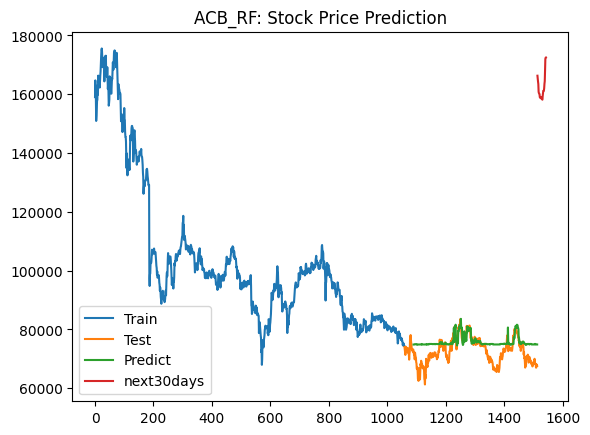

In [57]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")
# plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size+31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="next30days")


# # Dự đoán 30 điểm tiếp theo
plt.legend()
plt.title('ACB_RF: Stock Price Prediction')
plt.show()

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
import numpy as np
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(y_test[0], test_predict[:, 0])


print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')


RMSE trên tập test là: 4542.531095965249
MAPE trên tập test là: 5.018372245882155 %
MDA trên tập test là: 31.44208037825059 %
